# NCI60 use case

In [1]:
library("ISLR") 
library("evaluomeR")
library("dplyr")
library("caret")
library("MLmetrics")
library("ggplot2")
library("ggrepel")
library("reshape2")

options(scipen=10)

Loading required package: SummarizedExperiment
Loading required package: GenomicRanges
Loading required package: stats4
Loading required package: BiocGenerics
Loading required package: parallel

Attaching package: 'BiocGenerics'

The following objects are masked from 'package:parallel':

    clusterApply, clusterApplyLB, clusterCall, clusterEvalQ,
    clusterExport, clusterMap, parApply, parCapply, parLapply,
    parLapplyLB, parRapply, parSapply, parSapplyLB

The following objects are masked from 'package:stats':

    IQR, mad, sd, var, xtabs

The following objects are masked from 'package:base':

    anyDuplicated, append, as.data.frame, basename, cbind, colnames,
    dirname, do.call, duplicated, eval, evalq, Filter, Find, get, grep,
    grepl, intersect, is.unsorted, lapply, Map, mapply, match, mget,
    order, paste, pmax, pmax.int, pmin, pmin.int, Position, rank,
    rbind, Reduce, rownames, sapply, setdiff, sort, table, tapply,
    union, unique, unsplit, which, which.max, which

In [2]:
packageVersion("evaluomeR")

[1] '1.7.10'

# Table of contents
* [Dataset](#dataset)
    * [Removing highly correlated metrics](#correlated)
    * [Top 200](#top)
* [evaluomeR - optimal $k$ analysis](#evaluomer)
    * [Stability plotting](#evaluomeR_stab_plot)
    * [Quality plotting](#evaluomeR_qual_plot)
* [PCA](#pca)
* [Sensitivity](#sensitivity)
* [CER](#cer)

# Dataset <a class="anchor" id="dataset"></a>

In [3]:
nci60 = as.data.frame(NCI60$data)
head(nci60)

,1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
V1,0.300000,1.180000,0.550000,1.140000,-0.265000,-7.000000e-02,0.350000,-0.315000,-0.45000000,-0.65498050,...,-0.9900195,0.000000,0.030000,-0.175000,0.6299805,-0.030000,0.0000000,0.280000,-0.340000,-1.930000
V2,0.679961,1.289961,0.169961,0.379961,0.464961,5.799610e-01,0.699961,0.724961,-0.04003899,-0.28501950,...,-0.2700585,-0.300039,-0.250039,-0.535039,0.1099415,-0.860039,-1.2500490,-0.770039,-0.390039,-2.000039
V3,0.940000,-0.040000,-0.170000,-0.040000,-0.605000,0.000000e+00,0.090000,0.645000,0.43000000,0.47501950,...,0.3199805,0.120000,-0.740000,-0.595000,-0.2700195,-0.150000,0.0000000,-0.120000,-0.410000,0.000000
V4,0.280000,-0.310000,0.680000,-0.810000,0.625000,-1.387779e-17,0.170000,0.245000,0.02000000,0.09501949,...,-1.2400200,-0.110000,-0.160000,0.095000,-0.3500195,-0.300000,-1.1500100,1.090000,-0.260000,-1.100000
V5,0.485000,-0.465000,0.395000,0.905000,0.200000,-5.000000e-03,0.085000,0.110000,0.23500000,1.49001949,...,0.5549805,-0.775000,-0.515000,-0.320000,0.6349805,0.605000,0.0000000,0.745000,0.425000,0.145000
V6,0.310000,-0.030000,-0.100000,-0.460000,-0.205000,-5.400000e-01,-0.640000,-0.585000,-0.77000000,-0.24498050,...,-0.5900195,0.000000,-0.740000,-2.095000,-1.3900200,-0.400000,0.6999902,0.290000,0.550000,0.000000


There are 14 types of classes within the dataset: **CNS**, **RENAL**, **BREAST**, **NSCLC**, **UNKNOWN**, **OVARIAN**, **MELANOMA**, **PROSTATE**, **LEUKEMIA**, **K562B-repro**, **K562A-repro**, **COLON**, **MCF7A-repro** and **MCF7D-repro**:

In [4]:
as.vector(unlist(unique(NCI60$labs)))

[1] "CNS"         "RENAL"       "BREAST"      "NSCLC"       "UNKNOWN"    
 [6] "OVARIAN"     "MELANOMA"    "PROSTATE"    "LEUKEMIA"    "K562B-repro"
[11] "K562A-repro" "COLON"       "MCF7A-repro" "MCF7D-repro"

Here, we prepare the NCI60 dataset for the analysis:

- We add a column named `Description` containing the class (category) of each row
- Due to their small class size, we remove the two prostate cell lines and the unknown cell line, "PROSTATE" and "UNKNOWN" entires respectively.

In [5]:
nci60["labels"] = rownames(nci60)
nci60 = nci60[ , c("labels", names(nci60)[names(nci60) != "labels"])]
nci60["labels"] = NCI60$labs
colnames(nci60)[colnames(nci60) == 'labels'] <- 'Description'
nci60 = nci60[!grepl("UNKNOWN", nci60$Description),] # Remove UNKNOWN
nci60 = nci60[!grepl("PROSTATE", nci60$Description),] # Remove PROSTATE

## Removing highly correlated metrics <a class="anchor" id="correlated"></a>
We address the issue of multicorrelation by identifying and removing highly correlated metrics (absolute correlation, 1) from our dataset. First, we exclude the first column from the dataset `nci60`, where the column `Description` is. We then compute the correlation matrix R for data using the `cor` function. To pinpoint the metrics that exhibit perfect correlation (correlation coefficient of 1 or -1), we make use of the `findCorrelation` function from the `caret` package, setting a cutoff of 1. This function returns the names of the variables that are highly correlated, if any.

In [6]:
data = nci60[-1]
R = cor(data)
head(R)

1,2,3,4,5,6,7,8,9,10,...,6821,6822,6823,6824,6825,6826,6827,6828,6829,6830
1.00000000,0.3833056,0.22006157,0.08724557,-0.08602104,0.08949880,0.1158955,0.37934513,0.15316722,0.18856013,...,0.00107821,-0.13456921,-0.12645356,-0.201420268,-0.21480468,-0.04013097,-0.034189686,-0.02287118,-0.09639277,-0.06072415
0.38330561,1.0000000,0.36433000,0.21617498,0.16558775,0.21444133,0.3699355,0.07807990,0.24695819,0.07245724,...,-0.02944743,-0.10859360,-0.04041393,0.003900317,0.02573318,-0.04360088,0.000302537,-0.06442559,-0.03610617,-0.05866152
0.22006157,0.3643300,1.00000000,0.23689049,0.12153801,0.03343932,0.1134791,0.01143216,-0.05276462,0.23168582,...,0.05290187,0.01976031,0.07319763,0.045394869,0.07732554,-0.12526880,-0.036734630,0.12118781,0.09385166,0.08099348
0.08724557,0.2161750,0.23689049,1.00000000,0.13438601,0.12715055,0.0590030,-0.06803698,-0.01874263,-0.12446127,...,-0.22308278,-0.28758473,-0.23071174,-0.259432992,-0.09173215,-0.17711090,0.001642882,-0.03740982,-0.03359966,-0.01586329
-0.08602104,0.1655877,0.12153801,0.13438601,1.00000000,0.26872823,0.2303654,-0.05813832,-0.04957305,-0.14754158,...,-0.17174975,-0.20977705,-0.14449000,-0.072001176,-0.13047178,0.10183611,0.073267124,-0.02843955,0.04111594,-0.06184830
0.08949880,0.2144413,0.03343932,0.12715055,0.26872823,1.00000000,0.4908452,0.19822509,0.22885592,0.05951340,...,-0.34521929,-0.26279137,-0.29911896,-0.143450848,-0.21673796,-0.21725913,-0.298911041,-0.22827261,-0.23197988,-0.20448364


In [7]:
cor_metrics = findCorrelation(R, cutoff = 1, verbose = FALSE, names=TRUE)
length(cor_metrics)

[1] 0

Finally, we use `length(cor_metrics)` to determine the number of these highly correlated metrics. As this number is 0, we assess there are no highly correlated metrics.

## Top 200 <a class="anchor" id="top"></a>

We now filter the metrics for including only the top 200 with the greatest variance, as these metrics have the most significant impact on clustering.

In [8]:
variance = sort(sapply(nci60[-1], var), decreasing = TRUE)  # Sorted gene variance
nci60_var = as.data.frame(variance)
nci60_var["Description"] = rownames(nci60_var)

In [9]:
top_number = 200
top_rows = nci60_var[c(1:top_number), ]
head(top_rows)

,variance,Description
4701,11.942075,4701
4700,11.429800,4700
256,7.978482,256
16,7.715338,16
4699,7.711871,4699
6393,7.659845,6393


In [10]:
row_list = as.list(top_rows["Description"])
top_row_list = unlist(setdiff(row_list, names(nci60)))
top_nci60 = nci60[, top_row_list]
top_nci60["Description"] = nci60[rownames(top_nci60) %in% rownames(nci60), "Description"]
top_nci60 = top_nci60[ , c("Description", names(top_nci60)[names(top_nci60) != "Description"])] 

The dataframe `top_nci60` contains 200 genes (metrics) which provides the most variance.

In [11]:
head(top_nci60)

,Description,4701,4700,256,16,4699,6393,6149,286,6415,...,5721,6622,5336,1067,6288,5872,5489,78,127,3383
V1,CNS,5.770000,5.820000,-1.910000,-2.37,4.760000,5.4799900,0.000000,0.610000,5.230000,...,2.790000,1.210000,-0.890000,-1.055010,-2.1850100,0.045000,1.990000,2.360000,-1.305000,-0.5400195
V2,CNS,5.039961,5.069961,-1.980039,0.00,4.779961,5.7299510,-0.480039,-3.980039,5.329961,...,1.629961,1.599961,-1.060039,-1.055049,-3.4050490,0.874961,2.609961,0.869961,-0.375039,0.4799415
V3,CNS,-1.440000,-1.030000,-0.580000,0.00,0.000000,4.6299900,2.060000,-1.580000,0.000000,...,1.920000,-0.260000,0.000000,1.294990,-0.6850098,1.445000,0.200000,1.990000,0.705000,0.3199805
V4,RENAL,-2.420000,-2.420000,-1.880000,-1.02,-2.590000,1.2999900,5.190000,-4.880000,7.020000,...,3.200000,1.110000,1.060000,1.414990,-4.4750100,2.365000,1.080000,3.600000,-0.685000,0.1399805
V5,BREAST,-2.955000,-2.955000,-1.235000,0.00,-2.535000,-1.0550098,7.425000,-3.235000,4.395000,...,2.865000,1.245000,0.000000,-1.480010,-3.8300098,3.320000,-1.155000,-1.385000,-1.220000,0.4449805
V6,CNS,0.000000,-3.180000,-3.050000,-0.05,-1.170000,0.5899902,4.230000,-5.050000,-0.220000,...,2.860000,1.360000,0.000000,-1.425010,-2.2550100,1.615000,-0.970000,1.370000,-2.445000,-1.5400200


# evaluomeR - optimal $k$ analysis <a class="anchor" id="evaluomer"></a>
In this Section, evaluomeR executes an optimal $k$ analysis. First, stabilities and qualities are calculated, considering all the metrics in the dataset. The $k$ range is $k \in [3,10]$ and the clustering method is `kmeans`.

In [12]:
seed = 13606
k.range=c(3,10)
cbi = "kmeans"

Stability calculation with $k \in [3,10]$ and `kmeans`:

In [13]:
stab_range = stabilityRange(data=top_nci60, k.range=k.range, 
                            bs=100, seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
stab = standardizeStabilityData(stab_range)


Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


## Stability plotting <a class="anchor" id="evaluomeR_stab_plot"></a>

Stability plot

In [14]:
rownames(stab) = c("stab_kmeans")
stab$Metric = rownames(stab)
stab$Method = "kmeans"
stab_melt = melt(stab, id.vars = c("Metric", "Method"))

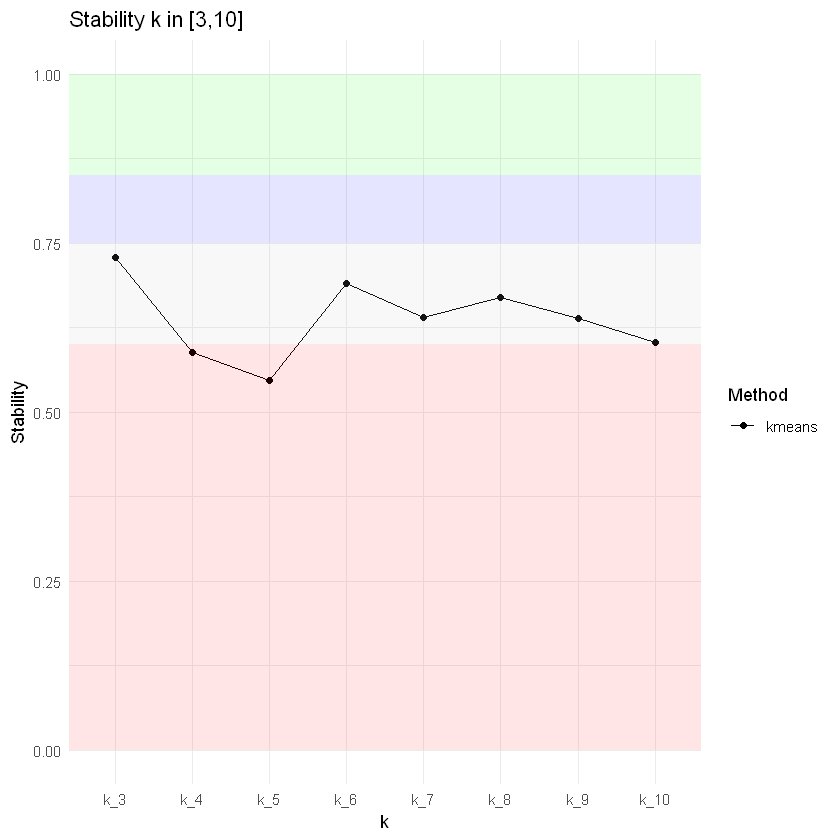

In [15]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('Stability k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")



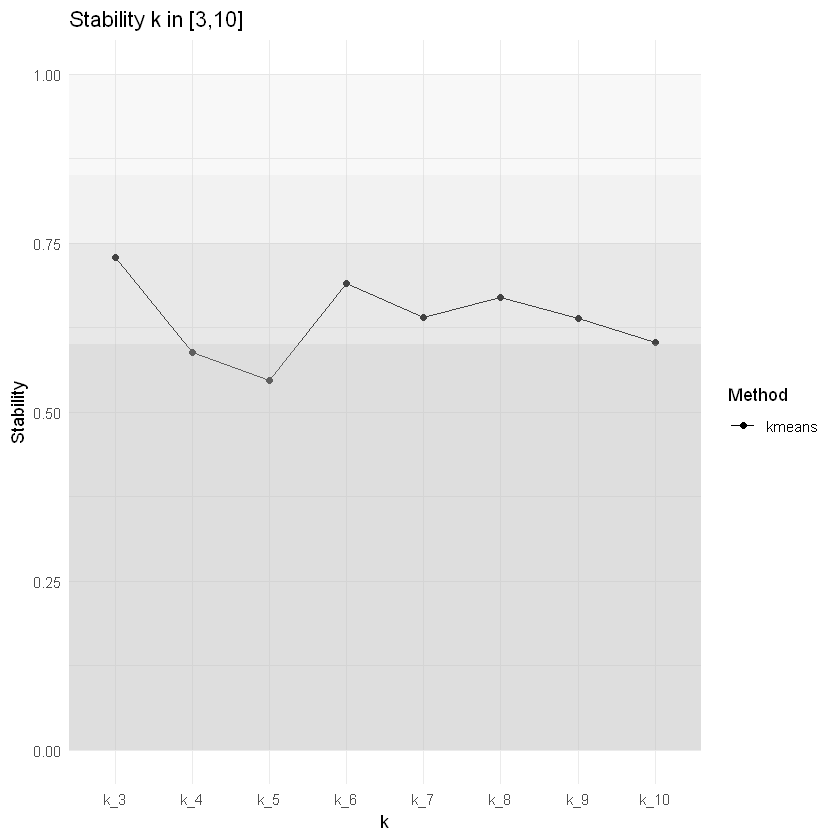

In [16]:
# Grayscale

# Define the grayscale palette
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(stab_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('Stability k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Stability'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding grayscale rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")


Quality calculation with $k \in [3,10]$ and `kmeans`.

In [17]:
qual_range = qualityRange(data=top_nci60, k.range=k.range, 
                            seed=seed,
                            all_metrics=TRUE,
                            cbi=cbi)
qual = standardizeQualityData(qual_range)


Data loaded.
Number of rows: 61
Number of columns: 201


Processing all metrics, 'merge', in dataframe (200)
	Calculation of k = 3
	Calculation of k = 4
	Calculation of k = 5
	Calculation of k = 6
	Calculation of k = 7
	Calculation of k = 8
	Calculation of k = 9
	Calculation of k = 10


## Quality plotting <a class="anchor" id="evaluomeR_qual_plot"></a>

Quality plot

In [18]:
rownames(qual) = c("qual_kmeans")
qual$Metric = rownames(qual)
qual$Method = "qual"
qual_melt = melt(qual, id.vars = c("Metric", "Method"))

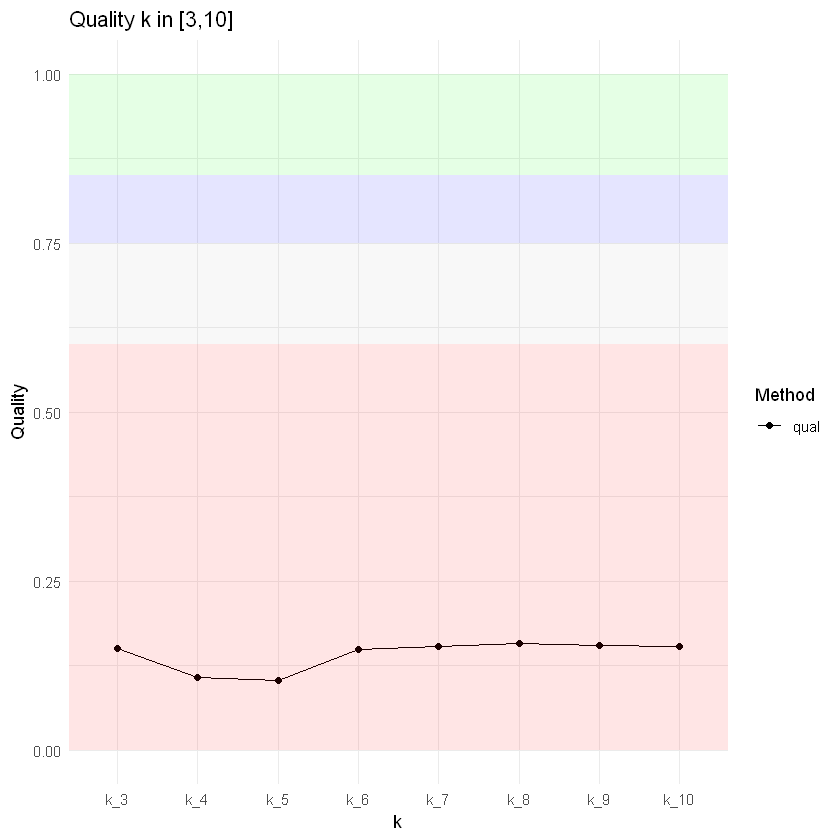

In [19]:
# Color
grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")

# Base ggplot
p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('Quality k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "green") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.1, fill = "blue") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.1, fill = "red")

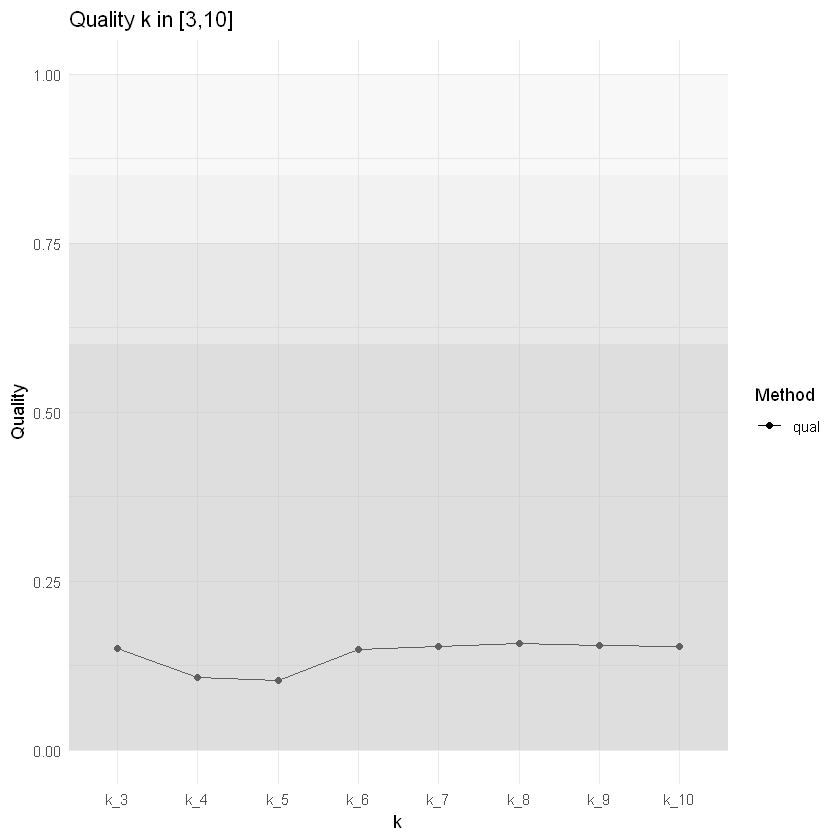

In [20]:
# Grayscale

grayscale_colors <- c("black", "darkgray", "gray", "lightgray", "white")


p <- ggplot(qual_melt, aes(x = variable, y = value, color = Method, group = Method)) +
  geom_point() +
  geom_line() +
  scale_color_manual(values = grayscale_colors) +
  labs(
    title = paste0('Quality k in [', k.range[1], ",", k.range[2], ']'),
    x = 'k',
    y = 'Quality'
  ) +
  scale_y_continuous(limits = c(0, 1)) +
  theme_minimal()

# Adding grayscale rectangles
p + 
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.85, ymax = 1, alpha = 0.1, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.75, ymax = 0.85, alpha = 0.2, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0.6, ymax = 0.75, alpha = 0.35, fill = "gray") +
  annotate("rect", xmin = -Inf, xmax = Inf, ymin = 0, ymax = 0.6, alpha = 0.5, fill = "gray")


Determining the optimal $k$ given the stabilities and qualities in `stab_range` and `qual_range` objects:

In [21]:
k_opt = getOptimalKValue(stab_range, qual_range, k.range= k.range)
optimal_k = k_opt$Global_optimal_k
optimal_k_str = paste0("k_", optimal_k)
print(paste0("Optimal k: ", optimal_k))

Processing metric: all_metrics

	Both Ks do not have a stable classification: '3', '8'

	Using '8' since it provides higher silhouette width



[1] "Optimal k: 8"


In [22]:
print(paste0("Stabilities and qualities per k with '", cbi, "' as clustering method"))
stab
qual
print(paste0("Stabily in k=", optimal_k,": ", stab[optimal_k_str]))
print(paste0("Quality in k=", optimal_k,": ", qual[optimal_k_str]))

[1] "Stabilities and qualities per k with 'kmeans' as clustering method"


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
stab_kmeans,0.7292307,0.5878163,0.5464581,0.689701,0.6398981,0.6699727,0.639195,0.6031684,stab_kmeans,kmeans


,k_3,k_4,k_5,k_6,k_7,k_8,k_9,k_10,Metric,Method
qual_kmeans,0.1502642,0.107444,0.1025745,0.1496112,0.1538648,0.1571863,0.1546125,0.1531244,qual_kmeans,qual


[1] "Stabily in k=8: 0.669972700910201"
[1] "Quality in k=8: 0.157186259501016"


# Clusters

In [23]:
# Internal method used to group individuals per cluster
individuals_per_cluster = function(qualityResult) {
  qual_df = as.data.frame(assay(qualityResult))


  cluster_pos_str = as.character(unlist(qual_df["Cluster_position"]))
  cluster_labels_str = as.character(unlist(qual_df["Cluster_labels"]))

  cluster_pos = as.list(strsplit(cluster_pos_str, ",")[[1]])
  cluster_labels = as.list(strsplit(cluster_labels_str, ",")[[1]])

  individuals_in_cluster = as.data.frame(cbind(cluster_labels, cluster_pos))
  colnames(individuals_in_cluster) = c("Individual", "InCluster")

  return(individuals_in_cluster)
}

In [24]:
cluster_individuals = individuals_per_cluster(assay(qual_range[optimal_k_str]))
for (cluster_i in 1:optimal_k) {
    ind_in_cluster = paste(unlist(cluster_individuals[cluster_individuals$InCluster == cluster_i, ]["Individual"]), collapse = ",")
    print(paste("Cluster", cluster_i, ":", ind_in_cluster))
    print("---")
}

[1] "Cluster 1 : BREAST,NSCLC,RENAL,OVARIAN,MELANOMA,OVARIAN,NSCLC,NSCLC"
[1] "---"
[1] "Cluster 2 : CNS,CNS,CNS,RENAL,BREAST,CNS,CNS,BREAST,NSCLC,NSCLC"
[1] "---"
[1] "Cluster 3 : MCF7A-repro,BREAST,MCF7D-repro,BREAST"
[1] "---"
[1] "Cluster 4 : RENAL,RENAL,RENAL,RENAL,RENAL,RENAL,RENAL"
[1] "---"
[1] "Cluster 5 : K562B-repro,K562A-repro,LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA,LEUKEMIA"
[1] "---"
[1] "Cluster 6 : MELANOMA,BREAST,BREAST,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA,MELANOMA"
[1] "---"
[1] "Cluster 7 : COLON,COLON,COLON,COLON,COLON,COLON,COLON"
[1] "---"
[1] "Cluster 8 : OVARIAN,OVARIAN,OVARIAN,OVARIAN,NSCLC,NSCLC,NSCLC,LEUKEMIA,NSCLC"
[1] "---"


# PCA <a class="anchor" id="pca"></a>
We employ Principal Component Analysis (PCA) as a dimensionality reduction technique to facilitate the visualization of clusters within our dataset. PCA allow us to transform the original high-dimensional data into a lower-dimensional space, while preserving as much of the variability as possible.

In [25]:
top_nci60["inCluster"] = as.numeric(cluster_individuals$InCluster)
pca_matrix = top_nci60 %>% select(-Description, -inCluster)
pca_result <- prcomp(pca_matrix, scale. = TRUE)
pca_df <- data.frame(pca_result$x)
pca_df$Cluster <- as.factor(top_nci60$inCluster)
pca_df$Individual <- top_nci60$Description
head(pca_df)

,PC1,PC2,PC3,PC4,PC5,PC6,PC7,PC8,PC9,PC10,...,PC54,PC55,PC56,PC57,PC58,PC59,PC60,PC61,Cluster,Individual
V1,-6.047292,-0.1633954,2.343101,-3.7542082,0.9101306,6.4385560,-1.4718647,0.2568147,-3.4710357,0.2371819,...,0.5443508,-0.93217559,-0.40614412,-0.33202684,-0.29064548,1.45975628,-0.35816434,-2.220446e-16,2,CNS
V2,-5.928062,-1.4008178,2.591172,-2.9873006,0.6213681,7.5243878,-2.2293323,-0.1076932,-3.5885014,-2.0967271,...,-0.5501516,0.73731686,0.28332566,0.28925844,0.27986086,-1.40201579,0.35144976,3.885781e-16,2,CNS
V3,-8.032512,0.6220568,2.554242,-0.7701399,4.2108007,2.0175085,-3.1203730,-0.1278904,-0.3633964,0.9184632,...,-0.5461150,-0.61011084,0.32372254,-0.40845604,-0.02209404,-0.40350996,-0.11359210,2.109424e-15,2,CNS
V4,-11.959122,-2.0505708,0.931178,-4.7920611,7.9077612,0.9908415,0.8599031,-3.7133015,-0.2454991,-1.6436616,...,0.4447826,0.02147934,0.12368870,-0.07768251,-0.03231038,0.07446244,0.05495832,-1.110223e-16,2,RENAL
V5,-13.832647,-1.1343743,4.009274,-3.0021119,6.1676820,-7.3072763,0.8183651,-3.9095351,1.0638898,-1.3703352,...,0.2375083,-0.45506626,-0.08622651,-0.46457167,-0.17632278,0.22166030,0.15110846,2.720046e-15,2,BREAST
V6,-8.145455,-2.0823536,3.913364,-3.4954706,3.5598213,-2.8922116,0.2768688,-3.0802177,1.5891418,-0.3036240,...,-0.9560074,0.15505998,0.10978059,0.39089483,0.13453252,-0.03949569,-0.08595763,-1.609823e-15,2,CNS


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"

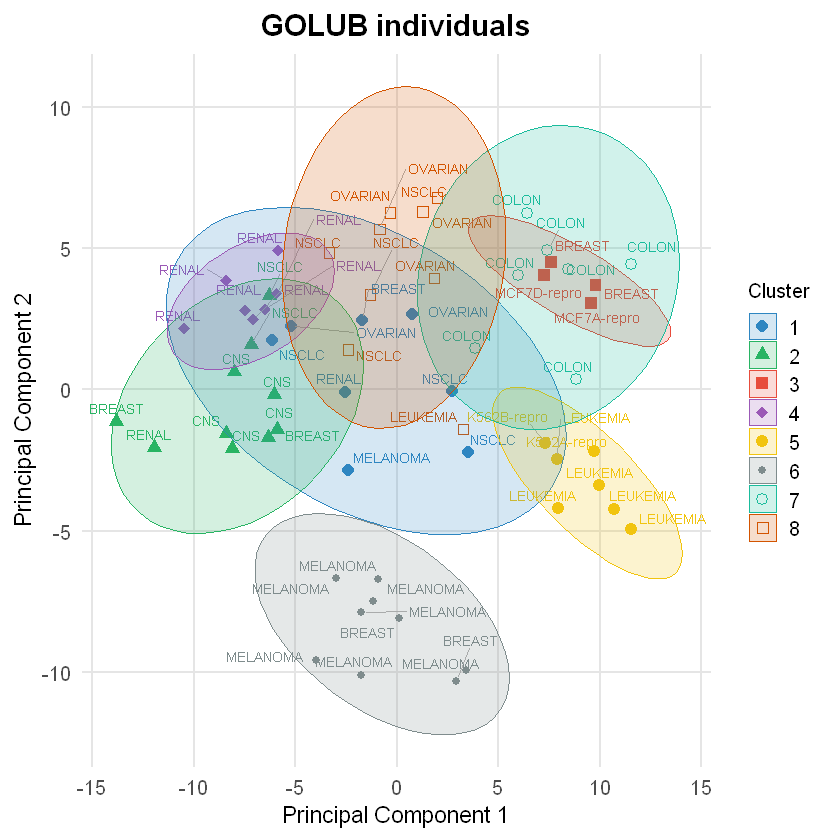

In [54]:
custom_colors <- custom_colors <- c("#2E86C1", "#28B463", "#E74C3C", "#9B59B6", "#F1C40F", 
                                    "#7F8C8D", "#1ABC9C", "#D35400", "#2980B9", "#8E44AD")

cluster_shapes <-  c(16, 17, 15, 18, 19, 20, 21, 22, 23, 24)

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1, 
    hjust = 1, 
    size = 3,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes) +
  scale_color_manual(values = custom_colors) +
  scale_fill_manual(values = custom_colors) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


Warning message:
"The following aesthetics were dropped during statistical transformation: label.
i This can happen when ggplot fails to infer the correct grouping structure in
  the data.
i Did you forget to specify a `group` aesthetic or to convert a numerical
  variable into a factor?"

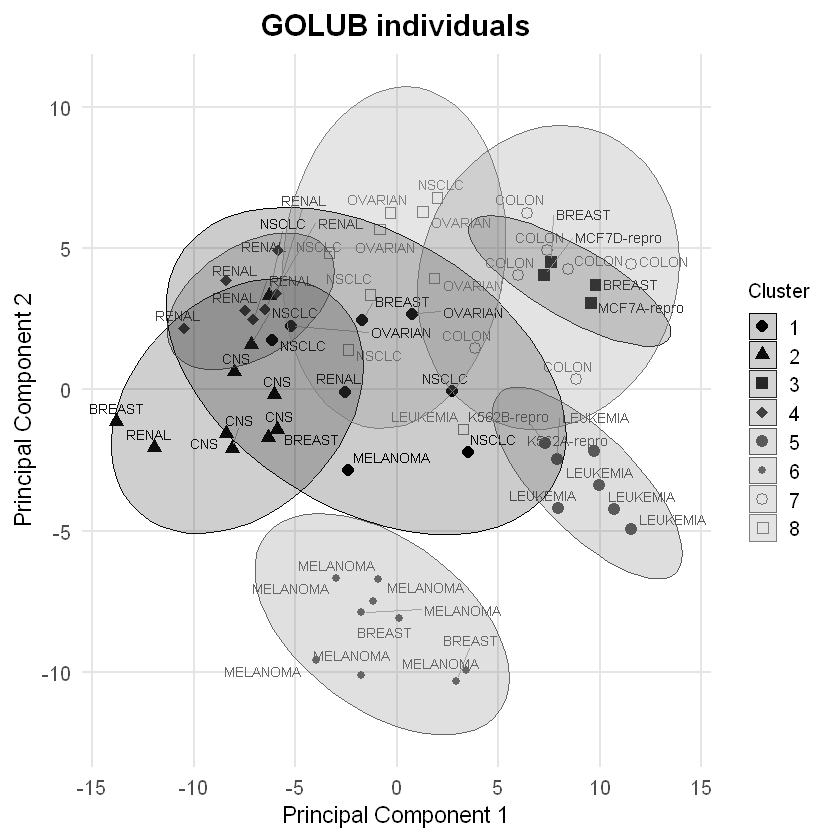

In [58]:
custom_colors <- c("black", "gray5", "gray15", "gray25", "gray35", "gray40", "gray45", "gray50")

cluster_shapes <-  c(16, 17, 15, 18, 19, 20, 21, 22, 23, 24)

ggplot(pca_df, aes(x = PC1, y = PC2, shape = Cluster, color = Cluster, label = Individual)) +
  geom_point(size = 3) +
  geom_text_repel(
    vjust = 1, 
    hjust = 1, 
    size = 3,
    show.legend = FALSE,
    point.padding = 0.25,
    box.padding = 0.25,
    max.overlaps = 15,
    segment.color = "grey70",
    segment.size = 0.2
  ) +
  stat_ellipse(aes(fill = Cluster), level = 0.95, alpha = 0.2, geom = "polygon") +
  labs(
    title = "GOLUB individuals",
    x = "Principal Component 1",
    y = "Principal Component 2"
  ) +
  scale_shape_manual(values = cluster_shapes) +
  scale_color_manual(values = custom_colors) +
  scale_fill_manual(values = custom_colors) +
  theme_minimal(base_size = 15) +
  theme(
    plot.title = element_text(hjust = 0.5, size = 18, face = "bold"),
    axis.title.x = element_text(size = 14),
    axis.title.y = element_text(size = 14),
    axis.text = element_text(size = 12),
    legend.position = "right",
    legend.title = element_text(size = 12),
    legend.text = element_text(size = 12),
    panel.grid.major = element_line(color = "grey90"),
    panel.grid.minor = element_blank()
  )


# Sensitivity <a class="anchor" id="sensitivity"></a>
In this Section we evaluate the sensitivity of our clustering using the `MLmetrics::Sensitivity` method. Sensitivity, or the true positive rate, measures the ability to correctly identify positive instances within the data. By focusing on sensitivity, we aim to ensure that our model effectively captures the relevant clusters, minimizing the number of false negatives. 

In [28]:
top_nci60["Class"] = top_nci60["Description"]
head(top_nci60)[, c("Description", "Class")]

,Description,Class
V1,CNS,CNS
V2,CNS,CNS
V3,CNS,CNS
V4,RENAL,RENAL
V5,BREAST,BREAST
V6,CNS,CNS


In [29]:
# KMEANS
# k=8
level_mapping <- c("NSCLC" = 1, "CNS" = 2, "BREAST" = 3,
                 "MCF7A-repro" = 3, "MCF7D-repro" = 3, "RENAL" = 4, 
                 "LEUKEMIA" = 5, "K562B-repro" = 5, "K562A-repro" = 5, 
                 "MELANOMA" = 6,  "COLON" = 7, "OVARIAN" = 8
                  )
map_strings_to_numbers <- function(strings) {
    return(as.numeric(level_mapping[strings]))
}
# Map categories with cluster number
top_nci60["Class_n"] = lapply(top_nci60["Class"], map_strings_to_numbers)
# Table of prediction vs actual classification
head(top_nci60)[, c("Description", "Class", "inCluster", "Class_n")]

,Description,Class,inCluster,Class_n
V1,CNS,CNS,2,2
V2,CNS,CNS,2,2
V3,CNS,CNS,2,2
V4,RENAL,RENAL,2,4
V5,BREAST,BREAST,2,3
V6,CNS,CNS,2,2


In [30]:
# Getting a vector of prediction vs actual classification
actual = as.factor(as.vector(unlist(top_nci60["Class_n"])))
predicted <- factor(as.vector(unlist(top_nci60["inCluster"])))

print("actual")
actual
print("predicted")
predicted

[1] "actual"


[1] 2 2 2 4 3 2 2 3 1 1 4 4 4 4 4 4 4 3 1 4 8 6 8 8 8 8 8 1 1 1 5 5 5 5 5 5 5 5
[39] 7 7 7 7 7 7 7 3 3 3 3 1 1 1 6 3 3 6 6 6 6 6 6
Levels: 1 2 3 4 5 6 7 8

[1] "predicted"


[1] 2 2 2 2 2 2 2 2 2 2 4 4 4 4 4 4 4 1 1 1 1 1 8 8 8 8 1 8 8 8 8 5 5 5 5 5 5 5
[39] 7 7 7 7 7 7 7 3 3 3 3 8 1 1 6 6 6 6 6 6 6 6 6
Levels: 1 2 3 4 5 6 7 8

In [31]:
sens <- MLmetrics::Sensitivity(y_pred = predicted, y_true = actual)
sens = format(round(sens*100, 2), nsmall = 2)
print(paste0("Sensitivity: ", sens, "%"))

[1] "Sensitivity: 33.33%"


# CER <a class="anchor" id="cer"></a>
To assess the overall accuracy of our clustering, we compute the Classification Error Rate (CER) and compare it with the gold standard classification. CER represents the proportion of misclassified instances, thus providing a clear measure of the clustering performance in assigning individuals to the correct clusters.

In [32]:
cer <- CER(predicted, actual)
cer = format(round(cer*100, 2), nsmall = 2)
print(paste0("CER: ", cer, "%"))

[1] "CER: 10.16%"
